In [13]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statistics import mean
from datetime import date
import file

In [14]:
# Define the ticker symbol
tickerSymbol = 'USD'

# Get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
history = tickerData.history(interval='1wk', start='2023-1-1', end=date.today())
# display(history)

In [15]:
gap = 0

option_prices = {
    1: [94/1.95],
    2: [90/4.05, 92/7.30, 72/3.8],
    3: [91/5.15],
    4: [81/5.4, 74/5.1, 131/12.1, 65/6.1],
    5: [100/7.05, 126/12.05, 65/6.25],
    6: [94/7.4, 92/11.30],
    7: [90/8.25, 72/7.5],
    8: [91/8.05, 131/16.05],
    9: [81/8.45, 100/9.4, 126/15.6, 65/8.25, 65/8.55],
    10: [93/13.95],
    12: [131/19.6],
    13: [100/11.5, 126/19.2],
    14: [94/10.55, 65/10.05],
    15: [90/11.15],
    16: [91/12.75],
    17: [81/11.3, 74/10.4],
    19: [72/12.6],
    21: [65/12.2],
    24: [93/19.50],
    26: [100/18.55, 131/27.85, 65/13.65],
    27: [94/17.25, 126/26.35],
    28: [90/16.9],
    29: [91/17.55],
    30: [81/14.95],
    32: [72/16.7],
    34: [65/16.1]
}

print('raw option leverages:')
for w in sorted(option_prices.keys()):
    print(f'\t{w:2}w', *[f'{x:4.1f}' for x in option_prices[w]])

option_leverage = {w:mean(option_prices[w]) for w in option_prices}

# normalize values so longer expirations have lower leverage
option_leverage = {k: v for k, v in zip(sorted(option_leverage.keys()), sorted(option_leverage.values(), reverse=True))}

print('sorted mean option leverage, break even:')
for w, v in sorted(option_leverage.items()):
    print(f'\t{w:2}w {v:4.1f} {gap + 100/v:4.1f}%')
print(f'option gap: {gap:.2f}%')

file.save_option_leverage(tickerSymbol, option_leverage)

raw option leverages:
	 1w 48.2
	 2w 22.2 12.6 18.9
	 3w 17.7
	 4w 15.0 14.5 10.8 10.7
	 5w 14.2 10.5 10.4
	 6w 12.7  8.1
	 7w 10.9  9.6
	 8w 11.3  8.2
	 9w  9.6 10.6  8.1  7.9  7.6
	10w  6.7
	12w  6.7
	13w  8.7  6.6
	14w  8.9  6.5
	15w  8.1
	16w  7.1
	17w  7.2  7.1
	19w  5.7
	21w  5.3
	24w  4.8
	26w  5.4  4.7  4.8
	27w  5.4  4.8
	28w  5.3
	29w  5.2
	30w  5.4
	32w  4.3
	34w  4.0
sorted mean option leverage, break even:
	 1w 48.2  2.1%
	 2w 17.9  5.6%
	 3w 17.7  5.7%
	 4w 12.7  7.8%
	 5w 11.7  8.6%
	 6w 10.4  9.6%
	 7w 10.3  9.8%
	 8w  9.7 10.3%
	 9w  8.8 11.4%
	10w  8.1 12.4%
	12w  7.7 13.0%
	13w  7.6 13.1%
	14w  7.1 14.0%
	15w  7.1 14.0%
	16w  6.7 15.0%
	17w  6.7 15.0%
	19w  5.7 17.5%
	21w  5.4 18.5%
	24w  5.3 18.8%
	26w  5.3 18.8%
	27w  5.2 19.3%
	28w  5.1 19.5%
	29w  5.0 20.2%
	30w  4.8 21.0%
	32w  4.3 23.2%
	34w  4.0 24.8%
option gap: 0.00%


In [16]:
max_weeks = 52
stock_change = [None]
option_performance = []
for weeks in range(1, max_weeks+1):
    stock_changes = history['Close'].pct_change(periods=weeks) * 100
    stock_change.append(stock_changes.median()*52/weeks)
    window_max = history['High'].rolling(window=pd.api.indexers.FixedForwardWindowIndexer(window_size=weeks)).max()

    if weeks in option_leverage:
        lvr = option_leverage[weeks]
        option_profits = ((stock_changes[weeks:] - gap) * lvr - 100).clip(lower=-100)
        mean_profit = option_profits.mean() * 52 / weeks # annualized
        median_profit = option_profits.median()
        positive_percent = (option_profits > 0).mean() * 100
        wmax = (((window_max / history['Open'] - 1) * 100 - gap) * lvr - 100).clip(lower=-100).median() - 100
        option_performance.append([weeks, mean_profit, positive_percent, wmax, median_profit])
        history[f'Option {weeks}w'] = option_profits # * 52 / weeks # annualized

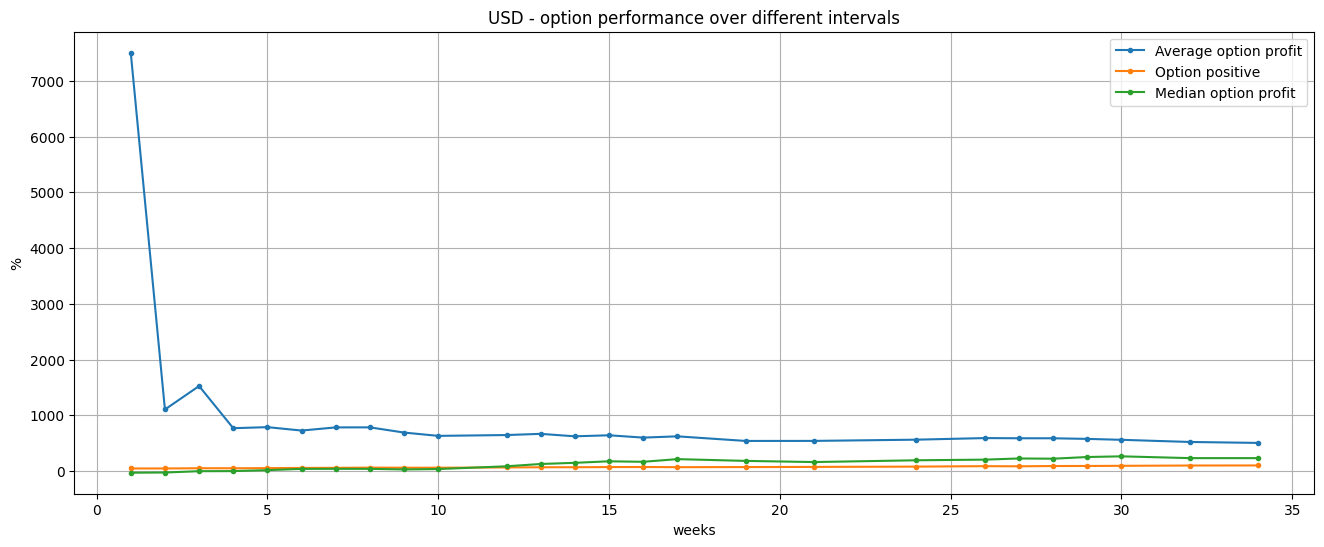

In [17]:
plt.figure(figsize=(16,6))
option_weeks = [p[0] for p in option_performance]
option_profit = [p[1] for p in option_performance]
option_positive = [p[2] for p in option_performance]
option_mprofit = [p[4] for p in option_performance]
option_score = [x * y / 100 for x, y in zip(option_profit, option_positive)]
plt.plot(option_weeks, option_profit, label='Average option profit', marker='.')
plt.plot(option_weeks, option_positive, label='Option positive', marker='.')
# plt.plot(option_weeks, option_score, label='Option score', marker='.')
plt.plot(option_weeks, option_mprofit, label='Median option profit', marker='.')
plt.legend()
plt.title(f'{tickerSymbol} - option performance over different intervals')
plt.xlabel('weeks')
plt.ylabel('%')
plt.grid()
plt.show()

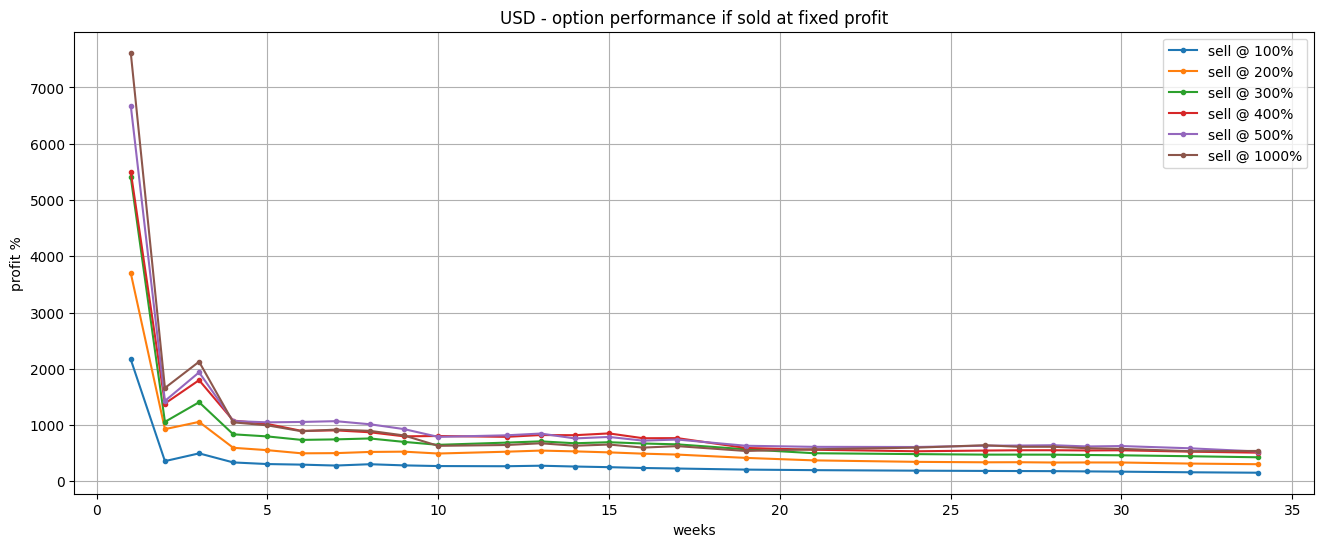

In [23]:
plt.figure(figsize=(16,6))

for maxprofit in [100,200,300,400,500,1000]:
    data = {}
    for weeks in option_leverage:
        lvr = option_leverage[weeks]
        WStart = history.Close.shift(weeks)
        WHigh = history.High.rolling(window=weeks).max()
        eow_profit = (((history.Close / WStart - 1) * 100 - gap) * lvr - 100).clip(lower=-100)
        wmax_profit = (((WHigh / WStart - 1) * 100 - gap) * lvr - 100).clip(upper=maxprofit)
        profit = wmax_profit.where(wmax_profit >= maxprofit, eow_profit)
        data[weeks] = profit[weeks:].mean() * 52/ weeks

    plt.plot(*zip(*sorted(data.items())), label=f'sell @ {maxprofit}%', marker='.')

plt.legend(loc='best')
plt.title(f'{tickerSymbol} - option performance if sold at fixed profit')
plt.xlabel('weeks')
plt.ylabel('profit %')
plt.grid()
plt.show()

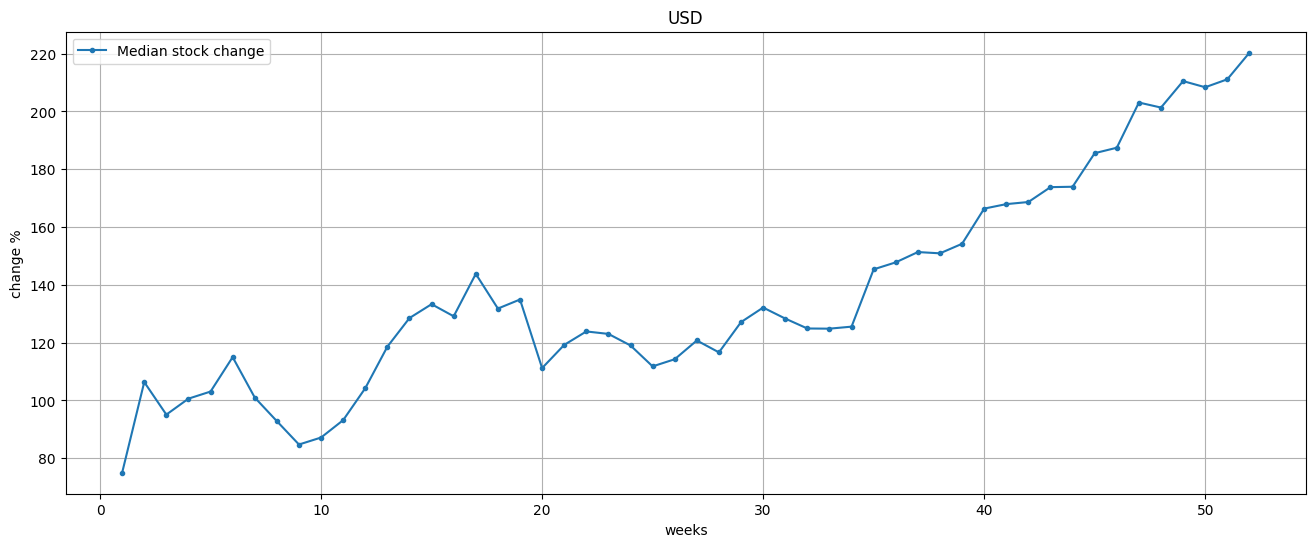

In [20]:
plt.figure(figsize=(16,6))
plt.plot(stock_change, label='Median stock change', marker='.')
plt.legend(loc='best')
plt.title(tickerSymbol)
plt.xlabel('weeks')
plt.ylabel('change %')
plt.grid()
plt.show()


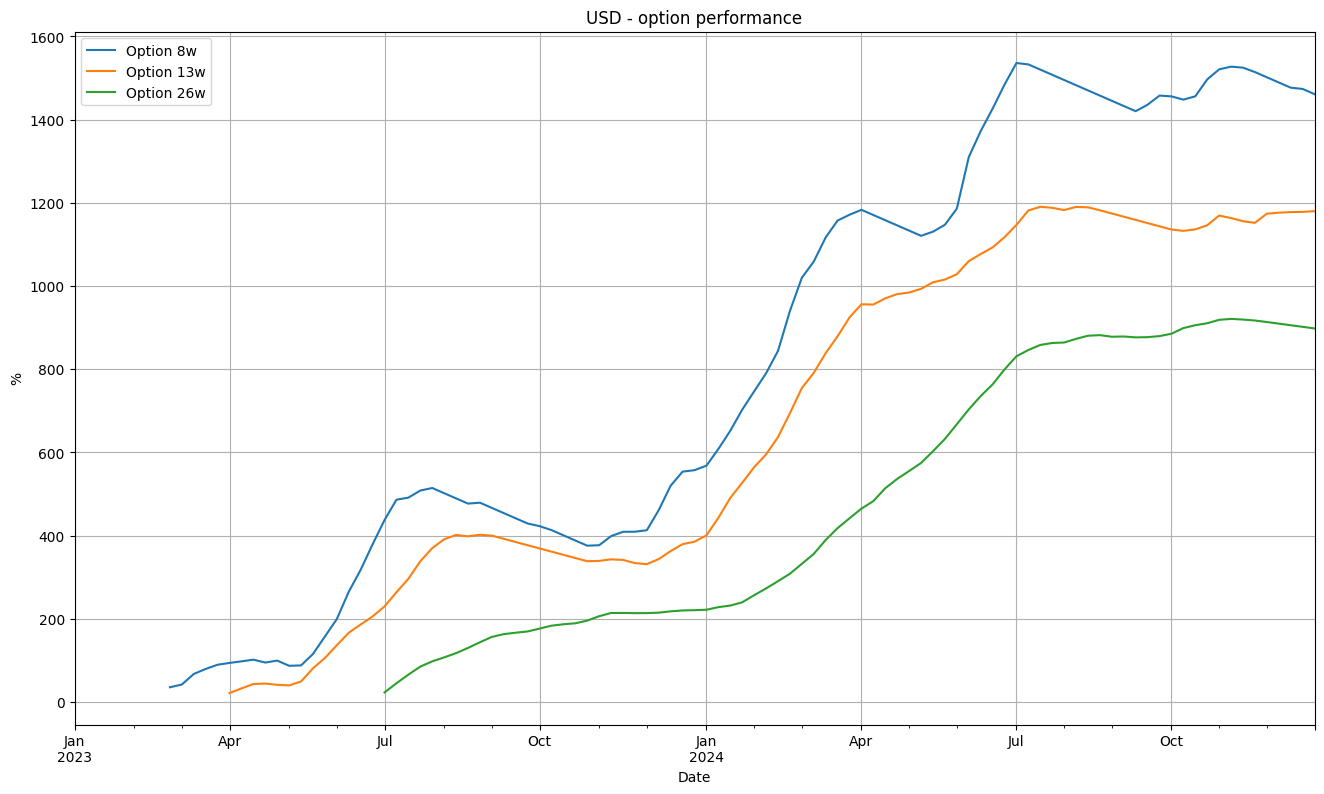

In [24]:
plt.figure(figsize=(16,9))

for w in [8,13,26]:
    (history[f'Option {w}w'].cumsum()/w).plot()

plt.legend(loc='upper left')
plt.title(f'{tickerSymbol} - option performance')
plt.ylabel('%')
plt.grid()
plt.show()
